# LA County coronavirus vaccine administration by city/community

### Load Python tools

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_latimes as lat
import glob
import path
import os

In [3]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Create a timeseries from coronavirus-tracker data

In [4]:
path = "/Users/mhustiles/data/github/coronavirus-tracker/_notebooks/data/raw/vaccines/los-angeles/"
all_files = glob.glob(os.path.join(path, "*.csv"))

In [5]:
df_from_each_file = (
    pd.read_csv(f, encoding="ISO-8859-1", low_memory=False) for f in all_files
)
concatenated_df = pd.concat(df_from_each_file, ignore_index=True)

In [6]:
df = concatenated_df.copy()

In [7]:
population = df[df["update_date"] == df["update_date"].max()][["area", "pop_2019"]]

In [8]:
population.head()

,area,pop_2019
4176,City of Agoura Hills,18019
4177,City of Alhambra,72940
4178,City of Arcadia,51103
4179,City of Artesia,14266
4180,City of Avalon,3077


### Strip out the strings placed in columns by the county

In [9]:
df = df[
    (df.vaccinations.str.strip() != "Unreliable Data")
    & (df.pop_2019.str.strip() != "No Pop Data")
    & (df.vaccinations_pct.str.strip() != "Unreliable Data")
    & (df.vaccinations_pct.str.strip() != "No Pop Data")
    & (df.vaccinations.str.strip() != "<5")
]

### Merge with population figures/rates from vaccine disparity project

In [11]:
disparity = pd.read_csv("../../vaccine-disparity/_workspace/neighborhoods_grouped.csv")

In [12]:
disparity_clean = disparity[
    [
        "name",
        "total_pop",
        "totalpop_17andunder",
        "totalpop_18to64",
        "totalpop_65andup",
        "totalpop_17andunder_percent",
        "totalpop_65andup_percent",
        "totalpop_65andup_percent",
        "majority_white",
        "majority_hispanic",
        "median_householdincome",
    ]
]

In [13]:
df_pop_merge = pd.merge(
    disparity_clean, df, left_on="name", right_on="area", indicator=True
)

In [14]:
df_pop_merge._merge.value_counts()

both          11924
right_only        0
left_only         0
Name: _merge, dtype: int64

In [15]:
df["week"] = pd.to_datetime(df["update_date"]).dt.week

In [16]:
df.week.value_counts()

13    2352
12    2352
11    2352
10    2342
14    2340
9     2338
8     1670
15     332
Name: week, dtype: int64

In [17]:
df.sort_values("update_date", ascending=False).head(10)

,area,vaccinations,pop_2019,vaccinations_pct,update_date,area_clean,week
4259,City of West Covina,38583,88873,43.4,2021-04-12,West Covina,15
4406,Unincorporated - Angeles National Forest,296,1096,27.0,2021-04-12,Angeles National Forest,15
4404,Unincorporated - Altadena,17205,36812,46.7,2021-04-12,Altadena,15
4403,Unincorporated - Agua Dulce,958,3736,25.6,2021-04-12,Agua Dulce,15
4402,Unincorporated - Acton,1652,6961,23.7,2021-04-12,Acton,15
4401,Los Angeles - Woodland Hills,27387,57284,47.8,2021-04-12,Woodland Hills,15
4400,Los Angeles - Winnetka,15821,41471,38.1,2021-04-12,Winnetka,15
4399,Los Angeles - Wilshire Center,13370,40599,32.9,2021-04-12,Wilshire Center,15
4398,Los Angeles - Wilmington,11236,42449,26.5,2021-04-12,Wilmington,15
4397,Los Angeles - Wholesale District,12332,32528,37.9,2021-04-12,Wholesale District,15


### Clean up data types

In [18]:
df["vaccinations"] = df["vaccinations"].astype(float)

In [19]:
df["pop_2019"] = df["pop_2019"].astype(float)

In [20]:
df["vaccinations_pct"] = ((df["vaccinations"] / df["pop_2019"]) * 100).round(2)

### Which week of the year? 

In [21]:
df["week"] = pd.to_datetime(df["update_date"]).dt.week

In [22]:
df["weekday"] = pd.to_datetime(df["update_date"]).dt.day_name()

### Just get the updates each Monday

In [23]:
df = df[df["weekday"] == "Monday"]

In [24]:
df[df["area"].str.contains("Narrows")].sort_values("update_date", ascending=True).head()

,area,vaccinations,pop_2019,vaccinations_pct,update_date,area_clean,week,weekday
15657,Unincorporated - Whittier Narrows,5.0,10.0,50.0,2021-03-15,Whittier Narrows,11,Monday
6261,Unincorporated - Whittier Narrows,5.0,10.0,50.0,2021-03-22,Whittier Narrows,12,Monday


### Widen the data for weekly average columns

In [77]:
df_pivot = (
    pd.pivot_table(
        df,
        values="vaccinations_pct",
        index="area",
        columns="week",
        aggfunc="mean",
    )
    .round(2)
    .reset_index()
)

In [78]:
df_pivot.head()

week,area,9,10,11,12,13,14,15
0,City of Agoura Hills,21.82,21.82,28.70,28.70,38.91,38.91,47.18
1,City of Alhambra,18.68,18.68,26.57,26.57,37.35,37.35,45.10
2,City of Arcadia,20.90,20.90,27.74,27.74,37.66,37.66,46.08
3,City of Artesia,20.83,20.83,25.73,25.73,35.27,35.27,42.27
4,City of Avalon,10.00,10.00,10.57,10.57,10.27,10.27,10.43


In [79]:
df_pivot.columns = ["pct_week_" + str(col) for col in df_pivot.columns]

In [80]:
df_pivot.rename(
    columns={"pct_week_area": "name", "week_pop_2019": "population"}, inplace=True
)

In [81]:
df_pivot.head()

,name,pct_week_9,pct_week_10,pct_week_11,pct_week_12,pct_week_13,pct_week_14,pct_week_15
0,City of Agoura Hills,21.82,21.82,28.70,28.70,38.91,38.91,47.18
1,City of Alhambra,18.68,18.68,26.57,26.57,37.35,37.35,45.10
2,City of Arcadia,20.90,20.90,27.74,27.74,37.66,37.66,46.08
3,City of Artesia,20.83,20.83,25.73,25.73,35.27,35.27,42.27
4,City of Avalon,10.00,10.00,10.57,10.57,10.27,10.27,10.43


### Merge with population figures/rates from vaccine disparity project

In [82]:
disparity = pd.read_csv("../../vaccine-disparity/_workspace/neighborhoods_grouped.csv")

In [83]:
disparity.head()

,Unnamed: 0,id,name,tract,tract_percent,Unnamed: 0_x,total_white,white_17andunder,white_18to64,white_65andup,total_hispanic,hispanic_17andunder,hispanic_18to64,hispanic_65andup,total_black,black_17andunder,black_18to64,black_65andup,total_native_american,native_american_17andunder,native_american_18to64,native_american_65andup,total_other,other_17andunder,other_18to64,...,total_asian_percent,asian_17andunder_percent,asian_18to64_percent,asian_65andup_percent,total_pacificislander_percent,pacificislander_17andunder_percent,pacificislander_18to64_percent,pacificislander_65andup_percent,nonwhite_percentage,totalpop_17andunder_percent,totalpop_18to64_percent,totalpop_65andup_percent,healthcare_workers_percent,majority_nonwhite,majority_black,majority_asian,majority_white,majority_american_indian_and_alaska_native,majority_hispanic,majority_18to64,majority_65andup,Unnamed: 0_y,neighborhood,median_householdincome,majorityhigherthanmedianincomeLA
0,0,1,Agoura Hills,56022.97,3.015807,15128,14294.386712,2565.000554,9240.747705,2488.638453,2060.384429,637.837458,1224.501950,0.000021,475.768824,167.211468,235.017585,73.539771,29.800880,16.466653,13.334227,0.000000,1360.190418,599.562387,692.685050,...,0.084100,0.076485,0.085944,0.084423,0.000000,0.000000,0.000000,0.000000,0.256824,0.215044,0.630619,0.159371,0.058344,True,False,False,True,False,False,True,False,0.0,Agoura Hills,121292.28270,True
1,1,2,Alhambra,161868.09,20.001823,47335,7500.641870,595.828265,4755.725927,2149.087677,30438.112581,7119.582940,19780.332201,0.000015,1892.355281,466.049670,1181.319618,244.985992,400.171514,26.149556,248.238252,125.783706,19460.555741,5174.416696,12865.429555,...,0.511584,0.393858,0.517814,0.598009,0.002586,0.005788,0.001722,0.002694,0.911412,0.169381,0.651545,0.179751,0.098254,False,False,True,False,False,False,True,False,1.0,Alhambra,61897.39551,False
2,2,3,Arcadia,126258.98,12.228262,37169,13381.530815,2115.148625,6685.762725,4580.619465,8147.091902,2441.806335,4856.815380,0.000006,990.881657,334.528273,525.148452,131.204932,70.730779,0.017364,24.079301,46.634115,5085.192956,1626.462948,3048.032363,...,0.605520,0.596204,0.642072,0.495743,0.001375,0.000157,0.001546,0.002277,0.783141,0.222551,0.592985,0.185774,0.103864,False,False,True,False,False,False,True,False,2.0,Arcadia,92543.61666,True
3,3,4,Artesia,55463.91,3.000606,18036,2543.198368,249.844904,1424.499924,868.853540,6684.617774,1596.709299,4444.111268,0.000097,852.042661,301.822462,497.791440,52.428760,59.913886,0.003356,0.049661,59.860869,4909.630360,1361.455844,3131.351644,...,0.367121,0.321175,0.387681,0.341434,0.002986,0.000024,0.001575,0.012780,0.848194,0.201502,0.644574,0.153806,0.181542,False,False,False,False,False,False,True,False,3.0,Artesia,67486.31903,False
4,4,5,Avalon,11981.00,0.830664,3881,1298.646327,95.240319,830.798525,372.607483,1704.840285,714.150321,926.143353,0.000333,3.354092,0.000000,3.354092,0.000000,0.000000,0.000000,0.000000,0.000000,583.530943,294.597351,263.280451,...,0.000558,0.000000,0.000027,0.003757,0.000324,0.000000,0.000558,0.000000,0.574229,0.265365,0.580198,0.144410,0.067722,False,False,False,False,False,True,True,False,4.0,Avalon,73854.46872,True


In [84]:
disparity_clean = disparity[
    [
        "name",
        "total_pop",
        #         "totalpop_17andunder_percent",
        #         "totalpop_18to64",
        #         "totalpop_65andup",
        "totalpop_17andunder_percent",
        "totalpop_65andup_percent",
        "nonwhite_percentage",
        "majority_white",
        "majority_hispanic",
        "median_householdincome",
    ]
]

In [85]:
df_merge = pd.merge(df_pivot, disparity_clean, on="name")

In [86]:
df_merge["change_week9_to_15"] = (
    ((df_merge["pct_week_15"] - df_merge["pct_week_9"]) / df_merge["pct_week_9"]) * 100
).round()

In [87]:
df_merge_slim = df_merge[
    [
        "name",
        "pct_week_9",
        "pct_week_15",
        "total_pop",
        "totalpop_17andunder_percent",
        "totalpop_65andup_percent",
        "nonwhite_percentage",
        "majority_white",
        "majority_hispanic",
        "median_householdincome",
        "change_week9_to_15",
    ]
].copy()

In [88]:
df_merge_slim[
    (df_merge_slim["pct_week_9"].notnull()) & (df_merge_slim["pct_week_15"].notnull())
].sort_values("change_week9_to_15", ascending=False).tail(10)

,name,pct_week_9,pct_week_15,total_pop,totalpop_17andunder_percent,totalpop_65andup_percent,nonwhite_percentage,majority_white,majority_hispanic,median_householdincome,change_week9_to_15
67,Los Angeles - Mandeville Canyon,35.04,60.56,3057.462093,0.263148,0.229847,0.122322,True,False,209930.44200,73.0
19,Los Angeles - Cheviot Hills,37.08,63.66,8640.938035,0.211283,0.202283,0.269950,True,False,139097.53580,72.0
215,Unincorporated - San Francisquito Canyon/Bouqu...,37.23,62.24,1631.928218,0.265975,0.090573,0.377579,True,False,139353.20000,67.0
7,Los Angeles - Beverly Crest,32.56,54.03,10869.083843,0.196094,0.237505,0.134145,True,False,181638.58650,66.0
240,Unincorporated - West LA,10.14,16.15,1154.826149,0.059281,0.181012,0.604410,False,False,56277.37386,59.0
187,Unincorporated - Lakewood,18.27,28.44,448.309524,0.217250,0.132287,0.801341,False,False,88042.64006,56.0
6,Los Angeles - Bel Air,34.30,52.68,7089.875517,0.209939,0.303493,0.231194,True,False,200555.13980,54.0
219,Unincorporated - Santa Catalina Island,8.91,12.85,75.170250,0.085670,0.146566,0.328672,True,False,44555.34990,44.0
222,Unincorporated - Saugus/Canyon Country,39.16,50.60,387.871012,0.068194,0.201725,0.394058,True,False,86114.50759,29.0
201,Unincorporated - Padua Hills,32.03,38.12,23.307818,0.229093,0.231904,0.510892,False,False,200691.50320,19.0


### Filter the dataframe to larger places

In [89]:
df_merge_slim["total_pop"] = df_merge_slim["total_pop"].fillna("").astype(int)

In [90]:
larger_places = df_merge_slim[df_merge_slim["total_pop"] > 5000]

### Which places with populations of more than 5,000 saw the largest pct increase from week 8 to week 15?

In [149]:
largest = (
    larger_places[
        (larger_places["pct_week_9"].notnull())
        & (larger_places["pct_week_15"].notnull())
    ]
    .sort_values("change_week9_to_15", ascending=False)
    .head(10)
)

In [150]:
largest

,name,pct_week_9,pct_week_15,total_pop,totalpop_17andunder_percent,totalpop_65andup_percent,nonwhite_percentage,majority_white,majority_hispanic,median_householdincome,change_week9_to_15,name_clean
113,Los Angeles - University Park,6.46,25.15,25962,0.119700,0.061099,0.785405,False,False,24656.25697,289.0,University Park
192,Unincorporated - Littlerock/Pearblossom,5.59,21.74,6786,0.284108,0.139551,0.700575,False,True,48752.94395,289.0,Littlerock/Pearblossom
107,Los Angeles - Thai Town,7.21,27.97,9314,0.107368,0.130282,0.527663,False,False,42919.83666,288.0,Thai Town
173,Unincorporated - Florence-Firestone,6.76,25.36,63373,0.317636,0.068662,0.995205,False,True,44489.45377,275.0,Florence-Firestone
188,Unincorporated - Lennox,7.29,27.16,19025,0.285876,0.064121,0.983711,False,True,51161.26784,273.0,Lennox
1,Los Angeles - Alsace,8.49,29.92,10053,0.209612,0.089146,0.939044,False,True,43093.10702,252.0,Alsace
42,Los Angeles - Green Meadows,6.82,23.61,21718,0.308907,0.074795,0.994338,False,True,41366.22880,246.0,Green Meadows
38,Los Angeles - Florence-Firestone,6.59,22.81,48257,0.319442,0.055256,0.994513,False,True,40483.50613,246.0,Florence-Firestone
121,Los Angeles - Vernon Central,6.52,22.51,50398,0.323692,0.062574,0.996621,False,True,40567.66783,245.0,Vernon Central
29,Los Angeles - Echo Park,12.06,41.02,13606,0.134642,0.106789,0.608251,False,False,80221.86169,240.0,Echo Park


### Mean income and older population share in places with largest pct increases

In [144]:
round(
    larger_places[
        (larger_places["pct_week_9"].notnull())
        & (larger_places["pct_week_15"].notnull())
    ]
    .sort_values("change_week9_to_15", ascending=False)
    .head(10)["median_householdincome"]
    .mean()
)

45771

In [145]:
round(
    larger_places[
        (larger_places["pct_week_9"].notnull())
        & (larger_places["pct_week_15"].notnull())
    ]
    .sort_values("change_week9_to_15", ascending=False)
    .head(10)["totalpop_65andup_percent"]
    .mean()
    * 100,
    2,
)

8.52

### Which places with populations of more than 5,000 saw the smallest pct increase from week 8 to week 14?

In [151]:
smallest = (
    larger_places[
        (larger_places["pct_week_9"].notnull())
        & (larger_places["pct_week_15"].notnull())
    ]
    .sort_values("change_week9_to_15", ascending=False)
    .tail(10)
)

In [152]:
smallest

,name,pct_week_9,pct_week_15,total_pop,totalpop_17andunder_percent,totalpop_65andup_percent,nonwhite_percentage,majority_white,majority_hispanic,median_householdincome,change_week9_to_15,name_clean
87,Los Angeles - Porter Ranch,27.41,51.24,33962,0.201494,0.221164,0.538788,False,False,129186.68000,87.0,Porter Ranch
78,Los Angeles - Pacific Palisades,30.40,56.17,18049,0.248622,0.236204,0.151819,True,False,187493.79670,85.0,Pacific Palisades
183,Unincorporated - Ladera Heights,25.83,47.48,12139,0.162826,0.215393,0.787777,False,False,102493.29750,84.0,Ladera Heights
105,Los Angeles - Tarzana,26.13,47.64,29276,0.199575,0.189168,0.333741,True,False,80716.71485,82.0,Tarzana
132,Los Angeles - Westwood,19.74,35.76,55923,0.088921,0.119817,0.488900,True,False,73222.64454,81.0,Westwood
33,Los Angeles - Encino,30.77,54.11,48064,0.207176,0.199472,0.242364,True,False,96824.75157,76.0,Encino
16,Los Angeles - Century City,34.26,59.68,12434,0.177379,0.234012,0.316788,True,False,119661.69920,74.0,Century City
19,Los Angeles - Cheviot Hills,37.08,63.66,8640,0.211283,0.202283,0.269950,True,False,139097.53580,72.0,Cheviot Hills
7,Los Angeles - Beverly Crest,32.56,54.03,10869,0.196094,0.237505,0.134145,True,False,181638.58650,66.0,Beverly Crest
6,Los Angeles - Bel Air,34.30,52.68,7089,0.209939,0.303493,0.231194,True,False,200555.13980,54.0,Bel Air


### Mean income and older population share in places with smalles pct increases

In [142]:
round(
    larger_places[
        (larger_places["pct_week_9"].notnull())
        & (larger_places["pct_week_15"].notnull())
    ]
    .sort_values("change_week9_to_15", ascending=False)
    .tail(10)["median_householdincome"]
    .mean()
)

131089

In [143]:
round(
    larger_places[
        (larger_places["pct_week_9"].notnull())
        & (larger_places["pct_week_15"].notnull())
    ]
    .sort_values("change_week9_to_15", ascending=False)
    .tail(10)["totalpop_65andup_percent"]
    .mean()
    * 100,
    2,
)

21.59

### Which places have the highest vaccination coverage right now?

In [45]:
larger_places[
    (larger_places["pct_week_9"].notnull()) & (larger_places["pct_week_15"].notnull())
][
    [
        "name",
        "pct_week_15",
        "majority_hispanic",
        "totalpop_17andunder_percent",
        "totalpop_65andup_percent",
    ]
].sort_values(
    "pct_week_15", ascending=False
).head(
    10
)

,name,pct_week_15,majority_hispanic,totalpop_17andunder_percent,totalpop_65andup_percent
19,Los Angeles - Cheviot Hills,63.66,False,0.211283,0.202283
88,Los Angeles - Rancho Park,62.71,False,0.207814,0.163806
16,Los Angeles - Century City,59.68,False,0.177379,0.234012
78,Los Angeles - Pacific Palisades,56.17,False,0.248622,0.236204
86,Los Angeles - Playa Vista,55.74,False,0.186668,0.104989
33,Los Angeles - Encino,54.11,False,0.207176,0.199472
7,Los Angeles - Beverly Crest,54.03,False,0.196094,0.237505
6,Los Angeles - Bel Air,52.68,False,0.209939,0.303493
10,Los Angeles - Brentwood,52.49,False,0.170538,0.190026
8,Los Angeles - Beverlywood,52.00,False,0.251519,0.136678


### Which places have the lowest vaccination coverage right now? 

In [46]:
larger_places[
    (larger_places["pct_week_9"].notnull()) & (larger_places["pct_week_15"].notnull())
][
    [
        "name",
        "pct_week_15",
        "majority_hispanic",
        "totalpop_17andunder_percent",
        "totalpop_65andup_percent",
    ]
].sort_values(
    "pct_week_15", ascending=False
).tail(
    10
)

,name,pct_week_15,majority_hispanic,totalpop_17andunder_percent,totalpop_65andup_percent
131,Los Angeles - Westlake,22.88,True,0.230150,0.093303
38,Los Angeles - Florence-Firestone,22.81,True,0.319442,0.055256
121,Los Angeles - Vernon Central,22.51,True,0.323692,0.062574
98,Los Angeles - South Park,22.28,True,0.322496,0.056965
15,Los Angeles - Central,22.14,True,0.306173,0.065168
17,Los Angeles - Century Palms/Cove,21.88,True,0.311102,0.073659
192,Unincorporated - Littlerock/Pearblossom,21.74,True,0.284108,0.139551
124,Los Angeles - Watts,21.42,True,0.358358,0.055530
120,Los Angeles - Vermont Vista,20.70,True,0.319345,0.067000
185,Unincorporated - Lake Los Angeles,19.11,True,0.302845,0.114554


### Merge the places with the largest and smallest increases in vax coverage for graphics

In [155]:
largest["size"] = "largest"
smallest["size"] = "smallest"

In [157]:
large_small = pd.concat([largest, smallest]).reset_index()

In [159]:
large_small_slim = [
    [
        "size",
        "name_clean",
        "pct_week_9",
        "pct_week_15",
        "change_week9_to_15",
    ]
]

In [159]:
large_small_slim

---

### Merge with geography

In [131]:
places_geo = gpd.read_file(
    "input/cities-neighborhoods-unincorporated-la-county-no-islands.geojson"
)

### Clean up places names

In [137]:
df_merge_slim["name_clean"] = (
    df_merge_slim["name"]
    .str.replace("City of", "", regex=False)
    .str.replace("Los Angeles - ", "", regex=False)
    .str.replace("Unincorporated - ", "", regex=False)
)

In [138]:
df_merge_slim.head()

,name,pct_week_9,pct_week_15,total_pop,totalpop_17andunder_percent,totalpop_65andup_percent,nonwhite_percentage,majority_white,majority_hispanic,median_householdincome,change_week9_to_15,name_clean
0,Los Angeles - Adams-Normandie,9.62,30.13,8343,0.232311,0.085110,0.952524,False,True,49595.00637,213.0,Adams-Normandie
1,Los Angeles - Alsace,8.49,29.92,10053,0.209612,0.089146,0.939044,False,True,43093.10702,252.0,Alsace
2,Los Angeles - Angelino Heights,11.32,40.92,2172,0.108905,0.093646,0.672396,False,False,73238.87045,261.0,Angelino Heights
3,Los Angeles - Arleta,14.75,35.92,34535,0.218514,0.119109,0.924363,False,True,81174.77394,144.0,Arleta
4,Los Angeles - Atwater Village,18.52,46.78,14994,0.158207,0.153406,0.703651,False,False,76128.19959,153.0,Atwater Village


In [139]:
len(df_merge_slim)

251

In [140]:
df_geo = places_geo.merge(df_merge_slim, left_on="NAME", right_on="name_clean")

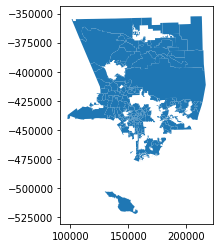

In [141]:
df_geo.plot()

---

### Export to csv

In [51]:
import datetime as dt

today = dt.datetime.today().strftime("%m-%d-%Y")

In [52]:
concatenated_df.to_csv(
    "output/vaccine-community/lac_vax_by_place_raw_table_" + today + ".csv",
    index=False,
)

In [53]:
df_pivot.to_csv(
    "output/vaccine-community/lac_vax_by_place_weeks_" + today + ".csv",
    index=False,
)

In [54]:
larger_places[
    (larger_places["pct_week_9"].notnull()) & (larger_places["pct_week_15"].notnull())
].sort_values("change_week9_to_15", ascending=False).head(10).to_csv(
    "output/vaccine-community/largest_vax_coverage_change_" + today + ".csv",
    index=False,
)

In [55]:
larger_places[
    (larger_places["pct_week_9"].notnull()) & (larger_places["pct_week_15"].notnull())
].sort_values("change_week9_to_15", ascending=False).tail(10).to_csv(
    "output/vaccine-community/smallest_vax_coverage_change_" + today + ".csv",
    index=False,
)

In [56]:
larger_places[
    (larger_places["pct_week_9"].notnull()) & (larger_places["pct_week_15"].notnull())
][["name", "pct_week_15", "total_pop"]].sort_values(
    "pct_week_15", ascending=False
).tail(
    10
).to_csv(
    "output/vaccine-community/lowest_coverage_" + today + ".csv",
    index=False,
)

In [57]:
larger_places[
    (larger_places["pct_week_9"].notnull()) & (larger_places["pct_week_15"].notnull())
][["name", "pct_week_15", "total_pop"]].sort_values(
    "pct_week_15", ascending=False
).head(
    10
).to_csv(
    "output/vaccine-community/highest_coverage_" + today + ".csv",
    index=False,
)